In [50]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy as sp
import pandas as pd
from pandas.io.json import json_normalize
import json
import datetime
import statsmodels.api as sm
from statsmodels.tsa import stattools, ar_model
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from statsmodels.tsa.api import VAR, DynamicVAR

In [10]:
def convert_datetime(name):
    json = pd.read_json('../data/downloads/' + name + '_download.json')
    df_json = pd.DataFrame(json['downloads'])
    df = json_normalize(df_json['downloads'])
    df['day'] = pd.to_datetime(df['day'], infer_datetime_format=True)
    df.index = df['day']
    return df

def convert_star_week_datatime(name):
  name = name.split('/')
  fname = '../data/stars/' + name[0] +'_' + name[1] + '_stars.json'
  pkg = pd.read_json(fname)
  pkg = pd.Series(pd.to_datetime(pkg['staredAts'])).dt.date
  github_life = np.arange('2016-09-04', '2019-09-02', dtype='datetime64[D]')
  github_life = pd.Series(github_life, name='t').dt.date
  star_counts = []
  for d in github_life:
    count = pkg[pkg == d].count()
    star_counts.append(count)
  starsCount = pd.Series(star_counts, index=pd.date_range('2016-09-04', '2019-09-01'))
  return round(starsCount.resample(rule='W').mean())

def convert_week_datetime(name):
    df = convert_datetime(name)
    df_w = round(df.resample(rule="W").mean())
    return df_w

def convert_ts(name):
    df_w = convert_week_datetime(name)
    ts = sm.tsa.seasonal_decompose(df_w['downloads'].values, freq=52)
    return ts

In [8]:
n = np.arange('2016-09-04', '2019-09-02', dtype='datetime64[D]')
print(n)

['2016-09-04' '2016-09-05' '2016-09-06' ... '2019-08-30' '2019-08-31'
 '2019-09-01']


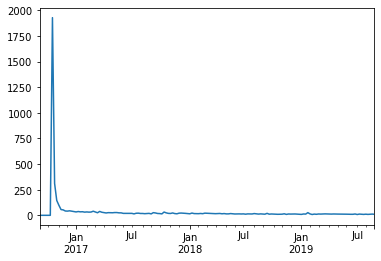

In [11]:
sr = convert_star_week_datatime('yarnpkg/yarn')
sr.plot()

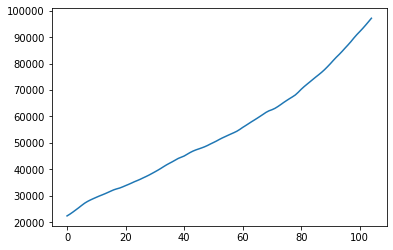

In [12]:
name = 'yarn'
df = convert_datetime(name)
df_w = round(df.resample(rule="W").mean())
# df_w['downloads'].plot()
ts = sm.tsa.seasonal_decompose(df_w['downloads'].values, freq=52)
# トレンドはスライスしないといけない
plt.plot(ts.trend[26:131])

In [58]:
ts = convert_ts('jest')
ts = ts.trend[26:131]

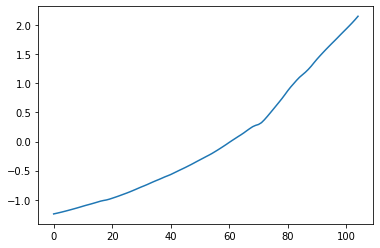

In [28]:
# yarn のトレンドを単位根過程に変換する
# そもそも scale を変換する
d = TimeSeriesScalerMeanVariance(mu=0. , std=1.).fit_transform(ts)
plt.plot(d[0])

In [94]:
trend = np.array([np.log10(i) for i in ts])
diff = pd.Series(trend).diff().dropna()
# diff = pd.Series(trend).diff().diff().dropna()
info_criteria = stattools.arma_order_select_ic(diff , ic=['aic', 'bic'])
info_criteria.aic_min_order, info_criteria.bic_min_order

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


((3, 1), (1, 1))

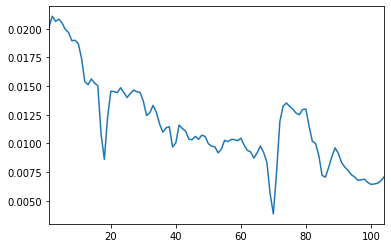

In [84]:
# diff.plot()
diff.plot()

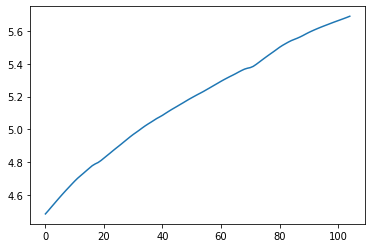

In [90]:
plt.plot(trend)

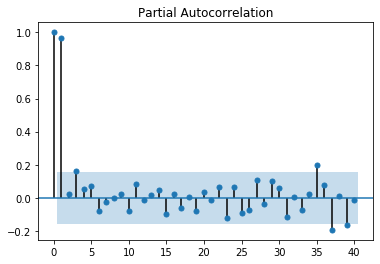

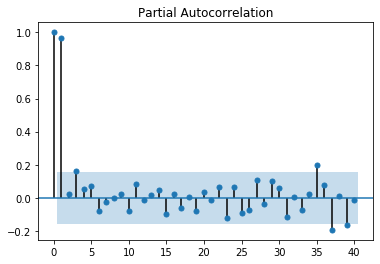

In [75]:
# sm.graphics.tsa.plot_acf(ts, lags=40)
sm.graphics.tsa.plot_pacf(df_w, lags=40)

# plt.plot(ts)

In [85]:
# y = pd.Series(ts,
#               index=pd.date_range('2017-03-05', periods=105, freq='W'))
y = diff
# print(y.head())
# ADF 検定
# トレンド項あり（2次まで）、定数項あり
ctt = stattools.adfuller(y, regression="ctt")
# トレンド項あり（1次）、定数項あり
ct = stattools.adfuller(y, regression="ct")
# トレンド項なし、定数項あり
c = stattools.adfuller(y, regression="c")
# トレンド項なし、定数項なし
nc = stattools.adfuller(y, regression="nc")
print('ctt:')
print(ctt)
print('ct:')
print(ct)
print('c:')
print(c)
print('nc:')
print(nc)

ctt:
(-3.6576218754372776, 0.07809090754789642, 7, 96, {'1%': -4.496104593777127, '5%': -3.8953966541883682, '10%': -3.5920270000994647}, -1020.6300715758537)
ct:
(-3.6660018787602713, 0.024696019672635034, 7, 96, {'1%': -4.056309393220125, '5%': -3.4572550874385124, '10%': -3.1544345187717013}, -1022.1107638693504)
c:
(-2.195091327102731, 0.20803184341427283, 12, 91, {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}, -1019.1909652048785)
nc:
(-2.2979981349226306, 0.02075210729253317, 12, 91, {'1%': -2.5907472213500786, '5%': -1.9443165668530238, '10%': -1.6141953984694208}, -1018.6272493333527)


In [91]:
model = ar_model.AR(trend)

for i in range(20):
    results = model.fit(maxlag=i+1)
    print('lag = ', i+1, 'aic : ', results.aic)

lag =  1 aic :  -12.337681568519914
lag =  2 aic :  -13.661102761877105
lag =  3 aic :  -13.890497782369842
lag =  4 aic :  -14.024767824805823
lag =  5 aic :  -14.075425205401581
lag =  6 aic :  -14.086897312876966
lag =  7 aic :  -14.156198065883975
lag =  8 aic :  -14.13943337110207
lag =  9 aic :  -14.183837264201419
lag =  10 aic :  -14.172634482077736
lag =  11 aic :  -14.152735461344282
lag =  12 aic :  -14.145222080634557
lag =  13 aic :  -14.129443185663018
lag =  14 aic :  -14.186319134979138
lag =  15 aic :  -14.171637941607399
lag =  16 aic :  -14.178491664123158
lag =  17 aic :  -14.14070031420667
lag =  18 aic :  -14.450436456505606
lag =  19 aic :  -14.47526837712222
lag =  20 aic :  -14.456646549443112


In [47]:
# download と star を連結した
# 157 から絞った値で見る
df = pd.concat([y, sr], axis=1)
df['2017-03-05':'2019-03-03']

,0,1
2017-03-05,22335.394231,33.0
2017-03-12,23020.105769,25.0
2017-03-19,23794.836538,38.0
2017-03-26,24612.826923,30.0
2017-04-02,25441.826923,27.0
2017-04-09,26315.576923,23.0
2017-04-16,27141.144231,26.0
2017-04-23,27812.971154,25.0
2017-04-30,28377.490385,25.0
2017-05-07,28887.836538,27.0


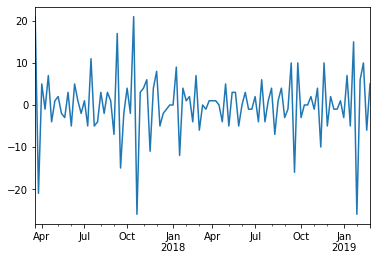

In [50]:
# 2次の階差をとった
y_diff = df.diff().diff().dropna()
y_diff[1].plot()

In [1]:
y_diff[0].plot()

NameError: name 'y_diff' is not defined

In [52]:
# トレンド項あり（2次まで）、定数項あり
ctt = stattools.adfuller(y_diff[0], regression="ctt")
ctt2 = stattools.adfuller(y_diff[1], regression="ctt")
# トレンド項あり（1次）、定数項あり
ct = stattools.adfuller(y_diff[0], regression="ct")
ct2 = stattools.adfuller(y_diff[1], regression="ct")
# トレンド項なし、定数項あり
# c = stattools.adfuller(y_diff, regression="c")
# トレンド項なし、定数項なし
# nc = stattools.adfuller(y_diff, regression="nc")
print('ctt:')
print(ctt)
print('ctt2:')
print(ctt2)
print('ct:')
print(ct)
print('ct2:')
print(ct2)
# print('c:')
# print(c)
# print('nc:')
# print(nc)

ctt:
(-4.339159051051507, 0.011160967934681739, 7, 95, {'1%': -4.497469532876512, '5%': -3.8960771573115616, '10%': -3.5924427193468436}, 974.9252910231842)
ctt2:
(-5.955598391317981, 1.5818747203337296e-05, 11, 91, {'1%': -4.503241586300428, '5%': -3.8989530387846667, '10%': -3.594198902372835}, 491.6350753386473)
ct:
(-4.360140022032919, 0.0025329901266307434, 7, 95, {'1%': -4.057372178160081, '5%': -3.4577588776789616, '10%': -3.154727848082811}, 972.9343678754417)
ct2:
(-6.009651067542471, 2.0965755844158355e-06, 11, 91, {'1%': -4.061865559807901, '5%': -3.4598875383872256, '10%': -3.155966861981154}, 490.25965794525894)


In [53]:
y_diff

# ダウンロード数とスター数の var モデルを作成
model_diff = VAR(y_diff)
model_diff.select_order(10).summary()

,AIC,BIC,FPE,HQIC
0,12.66,12.71,3.138e+05,12.68
1,12.19,12.35,1.965e+05,12.25
2,11.65,11.92,1.147e+05,11.76
3,11.56,11.94,1.046e+05,11.71
4,11.20,11.69*,7.288e+04,11.39
5,11.19,11.79,7.239e+04,11.43
6,11.16,11.86,7.027e+04,11.44
7,11.00,11.82,6.026e+04,11.33
8,10.89*,11.82,5.423e+04*,11.27*
9,10.95,11.98,5.738e+04,11.36


In [54]:
# AIC基準で最適なハイパーパラメタを選択したモデルのあてはめ
result_diff = model_diff.fit(maxlags=10, ic='aic')
# あてはめの結果を表示
result_diff.summary()

print(result_diff.k_ar)


8
